In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

from qdb.qdb_cache_api import QdbApi # 导入方式1：默认选择
# from qdb import QdbApi # 导入方式2：如果日内需要刷新缓存数据

q = QdbApi(user='read_only', password='read_only20716') # 可更换为个人用户名和密码增加权限


成功链接数据库：url=fundinfo.cq1tbd5lkqzo.rds.cn-northwest-1.amazonaws.com.cn:3306，user=read_only)
连接Arctic失败：mongo_uri=None)
[__init__] (connection user to mongodb)read_only (file_cache){'stock_daily': ['/shared/data/qdb_file_cache/stock/stock_daily.data', '/shared/data/qdb_file_cache/stock/stock_daily.lock', '/shared/data/qdb_file_cache/stock/stock_daily.ver'], 'future_daily': ['/shared/data/qdb_file_cache/future/future_daily.data', '/shared/data/qdb_file_cache/future/future_daily.lock', '/shared/data/qdb_file_cache/future/future_daily.ver']}


# 预定义函数

In [2]:
def cal_period_perf_indicator(df):
    """
    计算区间业绩指标(高级版)
    Input
        df: 价格或净值序列，DataFrame, index是datetime.date，每列是一只基金
    Output
        ['AnnRet1', 'AnnRet2', 'AnnVol', 'SR', 'MaxDD', 'Calmar'] 
    """

    assert type(df)==pd.DataFrame
    assert type(df.index[0])==dt.date
    
    indicators = ['AnnRet', 'AnnRet_Simple', 'AnnVol', 'SR', 'MaxDD', 'Calmar']
    res = pd.DataFrame(index=df.columns, columns=indicators)
    date_ordinal = pd.Series([dt.date.toordinal(e) for e in df.index])
    time_diff = date_ordinal - date_ordinal.shift(1) # 相对上一次净值的日期间隔
    for col in df:    
        p = df[col] # 单个资产价格或净值序列, pd.Series
        r = p.pct_change() # 涨幅
        annret = (p[-1] / p[0]) ** (365/(p.index[-1]-p.index[0]).days) - 1 # 复利年化收益
        r1 = r.values / time_diff # 日均收益
        annret1 = np.nanmean(r1) * 365 # 单利年化收益
        r2 = r.values / np.sqrt(time_diff) # 波动率调整后涨幅   
        annvol = np.nanstd(r2) * np.sqrt(365) # 年化波动率
        sr = (annret - 0.025) / annvol # 夏普比率
        mdd = np.min(p/p.cummax() - 1) # 最大回撤
        calmar = annret / -mdd
        res.loc[col] = [annret, annret1, annvol, sr, mdd, calmar]

    return res

## 择时回测

In [3]:
# 从数据接口读取基础数据
index_id= '000300.CSI'
start_date = dt.date(2005,1,1)
end_date = dt.date.today()

df = q.get_index_daily(index_id, start_date, end_date, fields=['open', 'high', 'low', 'close', 'volume', 'amount'])
df = df.set_index('date')
df['vwap'] = df['amount'] / df['volume']
df['ret'] = df['close'].pct_change()
df

,index_id,open,high,low,close,volume,amount,vwap,ret
date,,,,,,,,,
2005-01-04,000300.CSI,994.77,994.77,980.66,982.794,7.412870e+08,4.431980e+09,5.978764,NaN
2005-01-05,000300.CSI,981.58,997.32,979.88,992.564,7.119110e+08,4.529210e+09,6.362045,0.009941
2005-01-06,000300.CSI,993.33,993.79,980.33,983.174,6.288030e+08,3.921020e+09,6.235689,-0.009460
2005-01-07,000300.CSI,983.05,995.71,979.81,983.958,7.298690e+08,4.737470e+09,6.490850,0.000797
2005-01-10,000300.CSI,983.76,993.96,979.79,993.879,5.791700e+08,3.762930e+09,6.497108,0.010083
...,...,...,...,...,...,...,...,...,...
2022-04-20,000300.CSI,4130.54,4136.17,4060.50,4070.790,1.173320e+10,2.165370e+11,18.455068,-0.015505
2022-04-21,000300.CSI,4048.73,4086.44,3978.37,3995.830,1.327840e+10,2.270270e+11,17.097467,-0.018414
2022-04-22,000300.CSI,3967.20,4037.08,3953.72,4013.250,1.221020e+10,2.063720e+11,16.901607,0.004360


In [4]:
# 计算择时信号
N = 20


df['fcst'] = df['close'] / df['close'].shift(N) - 1
df

,index_id,open,high,low,close,volume,amount,vwap,ret,fcst
date,,,,,,,,,,
2005-01-04,000300.CSI,994.77,994.77,980.66,982.794,7.412870e+08,4.431980e+09,5.978764,NaN,NaN
2005-01-05,000300.CSI,981.58,997.32,979.88,992.564,7.119110e+08,4.529210e+09,6.362045,0.009941,NaN
2005-01-06,000300.CSI,993.33,993.79,980.33,983.174,6.288030e+08,3.921020e+09,6.235689,-0.009460,NaN
2005-01-07,000300.CSI,983.05,995.71,979.81,983.958,7.298690e+08,4.737470e+09,6.490850,0.000797,NaN
2005-01-10,000300.CSI,983.76,993.96,979.79,993.879,5.791700e+08,3.762930e+09,6.497108,0.010083,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-04-20,000300.CSI,4130.54,4136.17,4060.50,4070.790,1.173320e+10,2.165370e+11,18.455068,-0.015505,-0.044135
2022-04-21,000300.CSI,4048.73,4086.44,3978.37,3995.830,1.327840e+10,2.270270e+11,17.097467,-0.018414,-0.060974
2022-04-22,000300.CSI,3967.20,4037.08,3953.72,4013.250,1.221020e+10,2.063720e+11,16.901607,0.004360,-0.061562


In [5]:
# 逐日回测
pos_rule = 'long_only'
long_threshold = 0.05
short_threshold = -0.05

df['pos'] = np.nan
if pos_rule == 'long_only':
    df['pos'] = [1 if e>long_threshold else 0 for e in df['fcst'].shift(1)]
elif pos_rule == 'long_short':
    df['pos'] = [1 if e>long_threshold else 0 if e<short_threshold else 0.5 for e in df['fcst'].shift(1)]

df

,index_id,open,high,low,close,volume,amount,vwap,ret,fcst,pos
date,,,,,,,,,,,
2005-01-04,000300.CSI,994.77,994.77,980.66,982.794,7.412870e+08,4.431980e+09,5.978764,NaN,NaN,0
2005-01-05,000300.CSI,981.58,997.32,979.88,992.564,7.119110e+08,4.529210e+09,6.362045,0.009941,NaN,0
2005-01-06,000300.CSI,993.33,993.79,980.33,983.174,6.288030e+08,3.921020e+09,6.235689,-0.009460,NaN,0
2005-01-07,000300.CSI,983.05,995.71,979.81,983.958,7.298690e+08,4.737470e+09,6.490850,0.000797,NaN,0
2005-01-10,000300.CSI,983.76,993.96,979.79,993.879,5.791700e+08,3.762930e+09,6.497108,0.010083,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-20,000300.CSI,4130.54,4136.17,4060.50,4070.790,1.173320e+10,2.165370e+11,18.455068,-0.015505,-0.044135,0
2022-04-21,000300.CSI,4048.73,4086.44,3978.37,3995.830,1.327840e+10,2.270270e+11,17.097467,-0.018414,-0.060974,0
2022-04-22,000300.CSI,3967.20,4037.08,3953.72,4013.250,1.221020e+10,2.063720e+11,16.901607,0.004360,-0.061562,0


In [6]:
# 计算回测业绩
backtest_start_date = df.index[N]
df['stgy_ret'] = df['pos'] * df['ret']
df['stgy'] = (1+df['stgy_ret']).cumprod() * df.loc[backtest_start_date,'close']
df

,index_id,open,high,low,close,volume,amount,vwap,ret,fcst,pos,stgy_ret,stgy
date,,,,,,,,,,,,,
2005-01-04,000300.CSI,994.77,994.77,980.66,982.794,7.412870e+08,4.431980e+09,5.978764,NaN,NaN,0,NaN,NaN
2005-01-05,000300.CSI,981.58,997.32,979.88,992.564,7.119110e+08,4.529210e+09,6.362045,0.009941,NaN,0,0.0,955.951000
2005-01-06,000300.CSI,993.33,993.79,980.33,983.174,6.288030e+08,3.921020e+09,6.235689,-0.009460,NaN,0,-0.0,955.951000
2005-01-07,000300.CSI,983.05,995.71,979.81,983.958,7.298690e+08,4.737470e+09,6.490850,0.000797,NaN,0,0.0,955.951000
2005-01-10,000300.CSI,983.76,993.96,979.79,993.879,5.791700e+08,3.762930e+09,6.497108,0.010083,NaN,0,0.0,955.951000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-20,000300.CSI,4130.54,4136.17,4060.50,4070.790,1.173320e+10,2.165370e+11,18.455068,-0.015505,-0.044135,0,-0.0,6295.265228
2022-04-21,000300.CSI,4048.73,4086.44,3978.37,3995.830,1.327840e+10,2.270270e+11,17.097467,-0.018414,-0.060974,0,-0.0,6295.265228
2022-04-22,000300.CSI,3967.20,4037.08,3953.72,4013.250,1.221020e+10,2.063720e+11,16.901607,0.004360,-0.061562,0,0.0,6295.265228


,AnnRet,AnnRet_Simple,AnnVol,SR,MaxDD,Calmar
close,0.083072,0.082065,0.28369,0.204702,-0.723038,0.114893
stgy,0.115522,0.05995,0.152324,0.594278,-0.291273,0.396612


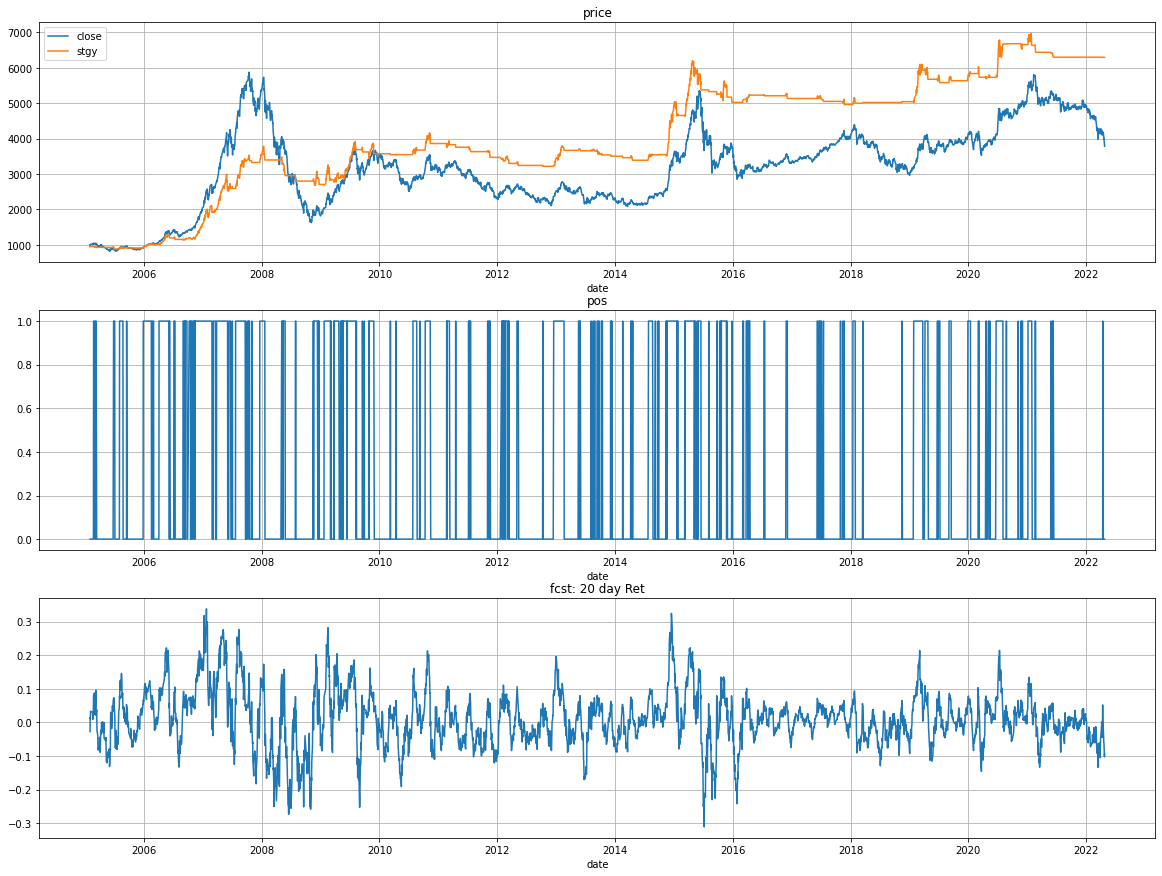

In [7]:
# 展示回测结果
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(3,1,1)
df.loc[backtest_start_date:,['close', 'stgy']].plot(ax=ax1, grid=True, title='price')
ax2 = fig.add_subplot(3,1,2)
df.loc[backtest_start_date:,'pos'].plot(ax=ax2, grid=True, title='pos')
ax3 = fig.add_subplot(3,1,3)
df.loc[backtest_start_date:,'fcst'].plot(ax=ax3, grid=True, title='fcst: %d day Ret' % N)

cal_period_perf_indicator(df.loc[backtest_start_date:,['close','stgy']])